# Single Training on GPU 1

# Quick Links <a name = "Top"></a>

<ol>
<li><a href = #setup>Begin Training</a></li>
</ol>

# Imports

In [1]:
import os

#os.environ["CUDA_VISIBLE_DEVICES"]='0'

print('Current Conda Environment: {}'.format(os.environ['CONDA_DEFAULT_ENV']))

Current Conda Environment: tf_ks


In [2]:
import talos as ta
from talos.model import lr_normalizer, early_stopper, hidden_layers

import tensorflow as tf
  
available_gpus = tf.config.experimental.list_physical_devices('GPU')
built_with_cuda = tf.test.is_built_with_cuda()

if not (not available_gpus) & built_with_cuda:
    print("The installed version of TensorFlow {} includes GPU support.\n".format(tf.__version__))
    print("Num GPUs Available: ", len(available_gpus), "\n")
else:
    print("The installed version of TensorFlow {} does not include GPU support.\n".format(tf.__version__))
    
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from tensorflow.compat.v1.keras import callbacks, backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD, Adagrad
from tensorflow.keras.layers import ReLU, LeakyReLU

from datetime import datetime
import pandas as pd
import numpy as np
import shutil

from copy import deepcopy

import time

from numpy.random import seed
seed(1)
tf.random.set_seed(1)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction = 0.99
sess = tf.compat.v1.Session(config = config)

#with tf.compat.v1.Session() as sess: 
#    sess.run()
#with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options.allow_growth=True,
#                                                   per_process_gpu_memory_fraction = 0.99)) as sess:
#    sess.run()
#with tf.compat.v1.Session(config=config) as sess: 
    #sess.run()
    

K.set_session(sess)

Using TensorFlow backend.


The installed version of TensorFlow 2.1.0 includes GPU support.

Num GPUs Available:  2 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7927081293181516921
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9105744200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14523180126670585795
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 9104897474
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16042835619553350581
physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5"
]


# Hilfsfunktionen

### Enum für Training-Set

In [3]:
from enum import Enum

class TrainingSet(Enum):
    SYNTHETIC = 1
    REAL = 2
    MIXED = 3

### Output Directory

* <i>SSD</i>, falls genug Speicher auf SSD im SymLink <i>fast_output</i> verfügbar ist
* <i>HDD</i>, falls möglicherweise zu wenig SSD-Speicher verfügbar ist $\rightarrow$ <i>output</i>

In [4]:
from enum import IntEnum

class OutputDirectory(IntEnum):
    HDD = 0
    SSD = 1
    
output_path = ['output', 'fast_output']

### Benutzerdefinierte Kostenfunktion & Metrik

In [5]:
def circular_mse(y_true, y_pred):
    max_error = tf.constant(360, dtype='float32')
    return K.mean(K.square(K.minimum(K.abs(y_pred - y_true), max_error - K.abs(y_pred - y_true))), axis = -1)

def circular_mae(y_true, y_pred):
    max_error = tf.constant(360, dtype='float32')
    return K.mean(K.minimum(K.abs(y_pred - y_true), K.abs(max_error - K.abs(y_pred - y_true))), axis = -1)

def custom_mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis = -1)

### Convert Label_Type into suitable label names.
$\Rightarrow$ Angular / Normalized $\rightarrow$ ['Elevation', 'Azimuth']

$\Rightarrow$ Stereographic $\rightarrow$ ['S_x', 'S_y']

In [6]:
def get_Label_Names(label_type):
    if label_type == 'Angular' or label_type == 'Normalized':
        return ['Elevation', 'Azimuth']
    elif label_type == 'Stereographic':
        return ['S_x', 'S_y']
    else:
        assert(True, 'LabelType Invalid')
        return None

### Convert String into Reduction Metric Function

In [7]:
def get_Reduction_Metric(metric):
    
    if metric == 'custom_mae':
        return [custom_mae]
    elif metric == 'tf.keras.metrics.MeanAbsoluteError()':
        return [tf.keras.metrics.MeanAbsoluteError()]
    elif metric == 'circular_mae':
        return [circular_mae]
    elif metric == 'mean_squared_error':
        return ['mean_squared_error']
    else:
        assert(False, 'Metric yet unknown - Please modify get_Reduction_Metric to meet your requirements')
        return None

### Automatische Optimizer Generierung aus String

In [8]:
def make_optimizer(optimizer):
    # [Adam, Nadam, Adagrad, RMSprop]
    if optimizer == "<class 'keras.optimizers.Adam'>":
        return Adam
    elif optimizer == "<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>":
        return Adam
    elif optimizer == "<class 'keras.optimizers.Nadam'>":
        return Nadam
    elif optimizer == "<class 'keras.optimizers.Adagard'>":
        return Adagard
    elif optimizer == "<class 'keras.optimizers.RMSprop'>":
        return RMSprop
    else:
        print('ERROR::: Unspecified Optimizer')

### Trainingsset-Typ nach String Converter

In [9]:
def trainingset_to_string(ts):
    if ts == TrainingSet.SYNTHETIC:
        return 'Synth'
    elif ts == TrainingSet.REAL:
        return 'Real'
    elif ts == TrainingSet.MIXED:
        return 'Mixed'
    else:
        print('Unknown TrainingSet')
        return None

### Generierung Datenpipeline (Angepasst für Talos)

In [10]:
def create_data(batch_size, num_samples, label_type):
    # if Block für synthetische Daten, um nur auf realen Daten zu trainieren _USE_SYNTHETIC_TRAIN_DATA
    # 1. lege df_train und df_valid als leere Liste an
    # 2. If-block um Zeile df = ... bis df_valid
    
    if trainingset == TrainingSet.SYNTHETIC:
        df = pd.read_csv(_CSV_FILE)
        df_shuffled = df.sample(frac = 1, random_state = 1)
        df_train = df_shuffled[0 : int(num_samples * 0.8 // batch_size * batch_size)]
        df_valid = df_shuffled.drop(df_shuffled.index[0 : df_train.shape[0]])[0 : int(num_samples * 0.2 // batch_size * batch_size)]
        
    elif trainingset == TrainingSet.MIXED:
        df = pd.read_csv(_CSV_FILE)
        df_shuffled = df.sample(frac = 1, random_state = 1)
        df_train = df_shuffled[0 : int(num_samples * 0.8 // batch_size * batch_size)]
        df_valid = df_shuffled.drop(df_shuffled.index[0 : df_train.shape[0]])[0 : int(num_samples * 0.2 // batch_size * batch_size)]
        
        df_real = pd.read_csv(_CSV_FILE_REAL)
        df_shuffled_real = df_real.sample(frac = 1, random_state = 1)
        df_shuffled_real = df_shuffled_real.drop(df_shuffled_real.index[(df_shuffled_real.shape[0] - 61) : df_shuffled_real.shape[0]])
        df_train_real = df_shuffled_real[0: int(df_shuffled_real.shape[0] * 0.8 // batch_size * batch_size)]   
        df_valid_real = df_shuffled_real.drop(df_shuffled_real.index[0 : df_train_real.shape[0]])
        df_train = df_train.drop(df_train.index[df_train.shape[0] - df_train_real.shape[0] : df_train.shape[0]])
        df_valid = df_valid.drop(df_valid.index[df_valid.shape[0] - df_valid_real.shape[0] : df_valid.shape[0]])
        df_train = df_train.append(df_train_real)
        df_valid= df_valid.append(df_valid_real)
    
    elif trainingset == TrainingSet.REAL: # Add check for num_samples, once the real dataset increases
        df_real = pd.read_csv(_CSV_FILE_REAL)
        df_shuffled_real = df_real.sample(frac = 1, random_state = 1)
        df_shuffled_real = df_shuffled_real.drop(df_shuffled_real.index[(df_shuffled_real.shape[0] - 61) : df_shuffled_real.shape[0]])
        df_train = df_shuffled_real[0 : int(df_shuffled_real.shape[0] * 0.8 // batch_size * batch_size)]   
        df_valid = df_shuffled_real.drop(df_shuffled_real.index[0 : df_train.shape[0]])
        
    else:
        print('Create_Data :: should not have reached here')
        

        
    if _USE_DATA_AUGMENTATION:
        train_data_generator = ImageDataGenerator(
            rescale = 1./255,
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            zoom_range = 0.1,
            brightness_range = (0.25, 0.75),
            fill_mode = 'nearest'
        )
    else:
        train_data_generator = ImageDataGenerator(
            rescale = 1./255
        )
        
    print('Y-Col: {}'.format(get_Label_Names(label_type)))
    print('Train Data Generator: ', end = '')
    
    train_generator = train_data_generator.flow_from_dataframe(
        dataframe = df_train,
        directory = _IMAGE_DIR,
        x_col = 'Filename RGB',
        y_col = get_Label_Names(label_type),
        class_mode = 'raw',
        target_size = (224, 224),
        color_mode = 'rgb',
        shuffle = True,
        seed = 77,
        batch_size = batch_size
    )
    
    valid_data_generator = ImageDataGenerator(
        rescale = 1./255
    )
    
    print('Validation Data Generator: ', end = '')
    
    valid_generator = valid_data_generator.flow_from_dataframe(
        dataframe = df_valid,
        directory = _IMAGE_DIR,
        x_col = 'Filename RGB',
        y_col = get_Label_Names(label_type),
        class_mode = 'raw',
        target_size = (224, 224),
        color_mode = 'rgb',
        shuffle = False,
        seed = 77,
        batch_size = batch_size
    )
    
    return train_generator, valid_generator

### Generierung Modell (Angepasst für Talos)

In [11]:
def grid_model_fine(x, y, x_val, y_val, params):
    print('==========================Params:')
    print(params)
    print('==========================')
    
    K.clear_session()
    
    train_generator, valid_generator = create_data(params['batch_size'], params['samples'], params['label_type'])
    tg_steps_per_epoch = train_generator.n // train_generator.batch_size
    vg_validation_steps = valid_generator.n // valid_generator.batch_size
    print('Steps per Epoch: {}, Validation Steps: {}'.format(tg_steps_per_epoch, vg_validation_steps))
    
    dropout_rate = params['dropout']
    first_neuron = params['first_neuron']
    
    if params['activation'] == 'leakyrelu':
        activation_layer = LeakyReLU(alpha = params['leaky_alpha'])
    elif params['activation'] == 'relu':
        activation_layer = ReLU()
    
    model = Sequential()
    cnn = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
    
    for layer in cnn.layers[:15]:
        layer.trainable = False
        #print(layer.name, layer.trainable)
        
    print('_________________________________________________________________')
    print('{:>16} {:>16}'.format('Network Layer', 'Trainable'))
    print('=================================================================')
    for layer in cnn.layers:
        print('{:>16} {:>16}'.format(layer.name, layer.trainable))
    print('_________________________________________________________________\n')
    
    model.add(cnn)
    
    fc = Sequential()
    fc.add(Flatten(input_shape = model.output_shape[1:])) # (7, 7, 512)
    
    fc.add(Dense(units = first_neuron, kernel_initializer = glorot_uniform(seed = 1)))
    fc.add(activation_layer)
    if dropout_rate > 0.0:
        fc.add(Dropout(rate = dropout_rate))
    
    print('Number Hidden Layers {}'.format(params['hidden_layers']))
    hidden_neuron_fraction = first_neuron
    for i in range(params['hidden_layers']):
        hidden_neuron_fraction = hidden_neuron_fraction // 2
        fc.add(Dense(units = hidden_neuron_fraction, kernel_initializer = glorot_uniform(seed = 1)))
        fc.add(activation_layer)
        if dropout_rate > 0.0:
            fc.add(Dropout(rate = dropout_rate))
    
    fc.add(Dense(units = 2, kernel_initializer = glorot_uniform(seed = 1)))
    fc.load_weights(_MODEL_DIR + _MODEL_TO_LOAD)
    model.add(fc)
    print('Fully Connected Layers added to Base Network')
    
    print('Using Loss: {} \nand Reduction Metric: {}'.format(
        params['loss_function'], 
        get_Reduction_Metric(params['reduction_metric'])))
    
    model.compile(
        #optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])*1e-2),
        optimizer = params['optimizer'](lr = lr_normalizer(params['lr'], params['optimizer']) * 1e-3),
        loss = params['loss_function'],
        metrics = get_Reduction_Metric(params['reduction_metric'])
    )
    print('Model was compiled')
    print(model.summary())
    print('_________________________________________________________________')
    
    checkpointer = callbacks.ModelCheckpoint(
        filepath = _LOG_DIR + 'CNN_Base_{}_Model_and_Weights_{}.hdf5'.format(_MODEL_TO_LOAD_INDEX, train_generator.n),
        monitor =  params['monitor_value'],
        verbose = 1,
        save_weights_only = False,
        save_best_only = True,
        mode = 'min'
    )
    print('Checkpointer was created')
    
    csv_logger = callbacks.CSVLogger(
        filename = _LOG_DIR + 'CNN_Base_{}_Logger_{}.csv'.format(_MODEL_TO_LOAD_INDEX, train_generator.n),
        separator = ',',
        append = False
    )
    print('CSV Logger was created')

    lr_reducer = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.1,
        patience = 13,
        verbose = 1,
        mode = 'min',
        min_delta = 0.0001
    )
    print('Learning Rate Reducer was created')
    
    early_stopper = callbacks.EarlyStopping(
        monitor = 'val_loss',
        min_delta = 0,
        #patience = 15,
        patience = 20,
        verbose = 1,
        mode = 'min',
        restore_best_weights = True
    )
    print('Early Stopper was created')
    
    out = model.fit(
        x = train_generator,
        steps_per_epoch = tg_steps_per_epoch,
        validation_data = valid_generator,
        validation_steps = vg_validation_steps,
        callbacks = [checkpointer, csv_logger, lr_reducer, early_stopper],
        epochs = params['epochs'],
        workers = 8
    )
    
    return out, model

# Feinoptimierung <a name = "setup"></a><a href = #Top>Up</a></p>

#### Hyper Parameter

In [12]:
#     Adam = RMSprop + Momentum (lr=0.001)
#     Nadam = Adam RMSprop + Nesterov-Momentum (lr=0.002)
#     RMSprop = (lr=0.001)
#     SGD = (lr=0.01)
#     Adagrad

global_hyper_parameter = {
    'samples': None,
    'epochs': None,
    'batch_size': None,
    'optimizer': None,
    'lr': None,
    'first_neuron': None,
    'dropout': None,
    'activation': None,
    'leaky_alpha': None,
    'hidden_layers': None,
    # beginning from here, Values should only contain one single entry:
    # ===============================================================
    'label_type': ['Angular'], # Stereographic, Angular, Normalized
    'loss_function': None,
    'reduction_metric': None,
    'monitor_value': None
}


### Training Setup 

In [13]:
_RUN = 'SYNTH'
_LOSS = 'MSE'
_DATASET_NAME = '201019_2253_final'#'2020-05-28'
_DEVICE = 'GeForce_RTX_2080_Ti'#'TITAN_GPU1'

storage = OutputDirectory.SSD # 'fast_output' if ssd storage may suffice, 'output' otherwise

if global_hyper_parameter['label_type'][0] == 'Stereographic':
    _CSV_SYNTH_FILE_NAME = 'images_synthetisch_stereographic.csv'
    _CSV_REAL_FILE_NAME = 'images_real_stereographic.csv'
    
elif global_hyper_parameter['label_type'][0] == 'Angular':
    _CSV_SYNTH_FILE_NAME = 'labels_ks_RGB.csv'
    _CSV_REAL_FILE_NAME = 'images_real.csv'
    
elif global_hyper_parameter['label_type'][0] == 'Normalized':
    _CSV_SYNTH_FILE_NAME = 'images_synthetisch_normalized.csv'
    _CSV_REAL_FILE_NAME = 'images_real_normalized.csv'
    
else:
    assert(True, 'Label Type Invalid')

In [14]:
trainingset = TrainingSet.SYNTHETIC
_USE_DATA_AUGMENTATION = True

In [15]:
_IMAGE_DIR = '..\\..\\data_generation\\dataset\\{}\\'.format(_DATASET_NAME)
_CSV_FILE = _IMAGE_DIR + _CSV_SYNTH_FILE_NAME
_CSV_FILE_REAL = _IMAGE_DIR + _CSV_REAL_FILE_NAME

_note = '_Custom-MAE'

_MODEL_DIR = '..\\output\\{}_Regression_{}\\{}_{}_Base{}\\'.format(_RUN, _LOSS, _DATASET_NAME, global_hyper_parameter['label_type'][0], _note)
_NET_DIR = '{}_Regression_{}\\{}_{}_Top_1{}\\{}_TD\\'.format(_RUN, _LOSS, _DATASET_NAME, global_hyper_parameter['label_type'][0], _note, trainingset_to_string(trainingset))
_LOG_DIR = '..\\{}\\{}'.format(output_path[storage], _NET_DIR)

if(not os.path.exists(_LOG_DIR)):
    os.makedirs(_LOG_DIR)
else:
    input('Directory >>| {} |<< existiert bereits. Fortsetzen auf eigene Gefahr! (Weiter mit Enter)'.format(_LOG_DIR))

device_file = open(_LOG_DIR + '{}.txt'.format(_DEVICE), "a+")

Directory >>| ..\fast_output\SYNTH_Regression_MSE\201019_2253_final_Angular_Top_1_Custom-MAE\Synth_TD\ |<< existiert bereits. Fortsetzen auf eigene Gefahr! (Weiter mit Enter)


### Top 3 FC-Gewichte

In [16]:
base_results = _MODEL_DIR + '..\\{}_{}_Base{}_Results.csv'.format(_DATASET_NAME, global_hyper_parameter['label_type'][0], _note)
df = pd.read_csv(base_results).drop(columns = ['round_epochs', 'samples', 'epochs'], axis = 0)
sort_value = df['monitor_value'][0]
df = df.sort_values(sort_value, axis = 0, ascending = True, inplace = False, kind = 'quicksort', na_position = 'last')
print('Displaying: {}'.format(base_results))
df.head(10)

Displaying: ..\output\SYNTH_Regression_MSE\201019_2253_final_Angular_Base_Custom-MAE\..\201019_2253_final_Angular_Base_Custom-MAE_Results.csv


,Unnamed: 0,start,end,duration,loss,custom_mae,val_loss,val_custom_mae,activation,batch_size,dropout,first_neuron,hidden_layers,label_type,loss_function,lr,monitor_value,optimizer,reduction_metric
32,32,10/22/20-210538,10/22/20-210553,14.862882,4383.826411,40.741211,2547.475186,28.446991,leakyrelu,32,0.25,4096,0,Angular,mean_squared_error,5,val_custom_mae,<class 'tensorflow.python.keras.optimizer_v2.a...,custom_mae
123,123,10/22/20-212354,10/22/20-212407,12.900292,4370.115269,41.885189,2500.798960,28.509195,leakyrelu,64,0.25,4096,1,Angular,mean_squared_error,1,val_custom_mae,<class 'tensorflow.python.keras.optimizer_v2.a...,custom_mae
17,17,10/22/20-210249,10/22/20-210259,9.804774,4001.966997,39.212330,2567.742597,28.672417,leakyrelu,32,0.25,2048,0,Angular,mean_squared_error,5,val_custom_mae,<class 'tensorflow.python.keras.optimizer_v2.a...,custom_mae
37,37,10/22/20-210657,10/22/20-210713,16.076730,5342.255862,44.598431,2508.385596,29.009453,leakyrelu,32,0.25,4096,2,Angular,mean_squared_error,2,val_custom_mae,<class 'tensorflow.python.keras.optimizer_v2.a...,custom_mae
126,126,10/22/20-212434,10/22/20-212447,12.947577,4892.983958,44.019562,2545.006084,29.102833,leakyrelu,64,0.25,4096,2,Angular,mean_squared_error,1,val_custom_mae,<class 'tensorflow.python.keras.optimizer_v2.a...,custom_mae
109,109,10/22/20-212138,10/22/20-212146,8.363558,4502.218566,42.888409,2549.238323,29.138407,leakyrelu,64,0.25,2048,1,Angular,mean_squared_error,2,val_custom_mae,<class 'tensorflow.python.keras.optimizer_v2.a...,custom_mae
36,36,10/22/20-210641,10/22/20-210657,15.954672,4115.395587,41.639866,2575.603947,29.298376,leakyrelu,32,0.25,4096,2,Angular,mean_squared_error,1,val_custom_mae,<class 'tensorflow.python.keras.optimizer_v2.a...,custom_mae
108,108,10/22/20-212129,10/22/20-212137,8.271264,3881.180195,40.146988,2558.554630,29.299927,leakyrelu,64,0.25,2048,1,Angular,mean_squared_error,1,val_custom_mae,<class 'tensorflow.python.keras.optimizer_v2.a...,custom_mae
18,18,10/22/20-210300,10/22/20-210310,10.109706,3871.796719,39.797153,2617.595140,29.322357,leakyrelu,32,0.25,2048,1,Angular,mean_squared_error,1,val_custom_mae,<class 'tensorflow.python.keras.optimizer_v2.a...,custom_mae
24,24,10/22/20-210403,10/22/20-210413,10.425704,4304.128398,43.794651,2461.137874,29.322683,leakyrelu,32,0.25,2048,3,Angular,mean_squared_error,1,val_custom_mae,<class 'tensorflow.python.keras.optimizer_v2.a...,custom_mae


### GridSerach

In [17]:
def get_params(top_results_index):
    
    #     Adam = RMSprop + Momentum (lr=0.001)
    #     Nadam = Adam RMSprop + Nesterov-Momentum (lr=0.002)
    #     RMSprop = (lr=0.001)
    #     SGD = (lr=0.01)
    #     Adagrad

    hyper_parameter = global_hyper_parameter

    hyper_parameter['samples'] = [100000] 
    hyper_parameter['epochs'] = [400]
    hyper_parameter['batch_size'] = [df.iloc[top_results_index]['batch_size']]
    hyper_parameter['optimizer'] = [make_optimizer(df.loc[top_results_index]['optimizer'])]
    hyper_parameter['lr'] = [df.iloc[top_results_index]['lr']]
    hyper_parameter['first_neuron'] = [df.iloc[top_results_index]['first_neuron']]
    hyper_parameter['dropout'] = [df.iloc[top_results_index]['dropout']]
    hyper_parameter['activation'] = [df.iloc[top_results_index]['activation']]
    hyper_parameter['leaky_alpha'] = [0.1] #Default bei LeakyReLU, sonst PReLU
    hyper_parameter['hidden_layers'] = [df.iloc[top_results_index]['hidden_layers']]
    
    hyper_parameter['loss_function'] = [df.iloc[top_results_index]['loss_function']]
    hyper_parameter['reduction_metric'] = [df.iloc[top_results_index]['reduction_metric']]
    hyper_parameter['monitor_value'] = [df.iloc[top_results_index]['monitor_value']]

    return hyper_parameter

..\..\data_generation\dataset\201019_2253_final\labels_ks_RGB.csv
buddha/rgb/buddha00000000-0-5-0-5.png


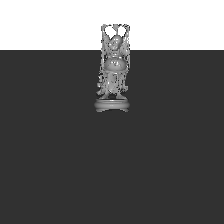

In [18]:
from IPython.display import Image
print(_CSV_FILE)
df = pd.read_csv(_CSV_FILE)
df.head()
print(df.iloc[0]['Filename RGB'])
#Image(df.iloc[0]['Filename RGB'])
#Image('../buddha00000001-0-5-0-10.png')
#Image('../../data_generation/dataset/201019_2253_final/buddha/rgb/buddha00000000-0-5-0-5.png')
Image('..\\..\\data_generation\\dataset\\201019_2253_final\\buddha\\rgb\\buddha00000000-0-5-0-5.png')

### Start Talos

In [90]:
dummy_x = np.empty((1, 2, 3, 224, 224))
dummy_y = np.empty((1, 2))

with tf.device('/device:GPU:1'):
    #for top_results_index in range(3):
    #for top_results_index in [0, 1]:
        top_results_index = 0
        _MODEL_TO_LOAD_INDEX = df.iloc[top_results_index].name
        _MODEL_TO_LOAD = 'Best_Weights_FC_{}.hdf5'.format(_MODEL_TO_LOAD_INDEX)

        _TMP_DIR = '..\\TMP_TALOS_{}'.format(_DEVICE)
        _CSV_RESULTS = _LOG_DIR + 'Talos_Results_Fine_Idx{}.csv'.format(_MODEL_TO_LOAD_INDEX)

        startTime = datetime.now()
        
        parameters = get_params(top_results_index)
        
        t = ta.Scan(
            x = dummy_x,
            y = dummy_y,
            model = grid_model_fine,
            params = parameters,
            experiment_name = _TMP_DIR,
            #shuffle=False,
            reduction_metric = parameters['reduction_metric'][0],
            disable_progress_bar = False,
            print_params = True,
            clear_session = True
        )

        print("Time taken:", datetime.now() - startTime)
        
        print('Writing Device File')
        device_file.write('Trained Model: {}'.format(_MODEL_TO_LOAD))

        df_experiment_results = pd.read_csv(_TMP_DIR + '\\' + os.listdir(_TMP_DIR)[0])
        df_experiment_results['Base'] = None
        for i in range(df_experiment_results.shape[0]):
            df_experiment_results['Base'][i] = _MODEL_TO_LOAD_INDEX

        if os.path.isfile(_CSV_RESULTS):
            df_experiment_results.to_csv(_CSV_RESULTS, mode = 'a', index = False, header = False)
        else:
            df_experiment_results.to_csv(_CSV_RESULTS, index = False)

        shutil.rmtree(_TMP_DIR)

KeyError: 'batch_size'

In [39]:
device_file.close()

# Copy Results to NAS if SSD Directory was selected

In [ ]:
def copy_directory(src, dst, symlinks = False, ignore = None):
    maxLen = 0
    message = ''        
    
    if not os.path.exists(dst):
        
        message = 'Creating Path: {}'.format(src)
        maxLen = max(maxLen, len(message))
        print(message + ' ' * (maxLen - len(message)), end = '\r')
        
        os.makedirs(dst)
        
    for item in os.listdir(src):
        
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        
        if os.path.isdir(s):
            
            message = 'Copying Directory: {}'.format(s)
            maxLen = max(maxLen, len(message))
            print(message + ' ' * (maxLen - len(message)), end = '\r')
            
            shutil.copytree(s, d, symlinks, ignore)
            
        else:
            
            if not os.path.exists(d): #or os.stat(s).st_mtime - os.stat(d).st_mtime > 1:
                
                message = 'Copying File: {}'.format(s)
                maxLen = max(maxLen, len(message))
                print(message + ' ' * (maxLen - len(message)), end = '\r')
                
                shutil.copy2(s, d)
        
        time.sleep(.5)
     
    message = 'Coyping... Done'
    maxLen = max(maxLen, len(message))
    print(message + ' ' * (maxLen - len(message)), end = '\n')

def delete_directory(src, terminator = '\n'):
    message = ''
    maxLen = 0
    
    try:
        message = 'Deleting {}'.format(src)
        maxLen = max(maxLen, len(message))
        print(message + ' ' * (maxLen - len(message)), end = '\r')
        
        shutil.rmtree(src)
        
    except OSError as e:
        message = 'Error: {} : {}'.format(src, e.strerror)
        maxLen = max(maxLen, len(message))
        print(message + ' ' * (maxLen - len(message)), end = '\n')
        return
    
    message = 'Deleting... Done'
    maxLen = max(maxLen, len(message))
    print(message + ' ' * (maxLen - len(message)), end = terminator)

    
def copy_fine_training(src, dst):
    copy_directory(src, dst)
    delete_directory(src, terminator = '\r')
    delete_directory(src + '..\\', terminator = '\r')
    if not os.listdir(src + '..\\..\\'):
        delete_directory(src + '..\\..\\', terminator = '\r')

In [ ]:
if(storage == OutputDirectory.SSD):
    _COPY_DIR = '..\\output\\{}'.format(_NET_DIR)
    copy_fine_training(_LOG_DIR, _COPY_DIR)

# <a name = "CMSE.Mixed"></a><a href = #Top>Up</a></p>